<a href="https://colab.research.google.com/github/sarahdell/DSPS_SDellorco/blob/main/Lab/My_DSPS2023_autoencoders_8dec23_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from copy import deepcopy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.signal import convolve2d

from tensorflow import keras
from keras.datasets import mnist
from keras import layers

!pip install icecream
from icecream import ic

rng = np.random.RandomState(1415)

# Load MNIST data

In [2]:
# Load the data and split it between train and test sets
(Xtrn, Ytrn), (Xtst, Ytst) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# Visualize dataset

In [8]:
Xtrn.shape #28 pixels high and 28 pixels across, 600000 handwritten number samples

(60000, 28, 28)

In [9]:
Ytrn.shape, Xtst.shape, Ytst.shape

((60000,), (10000, 28, 28), (10000,))

In [10]:
np.unique(Ytrn) #tells values of handwritten numbers

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

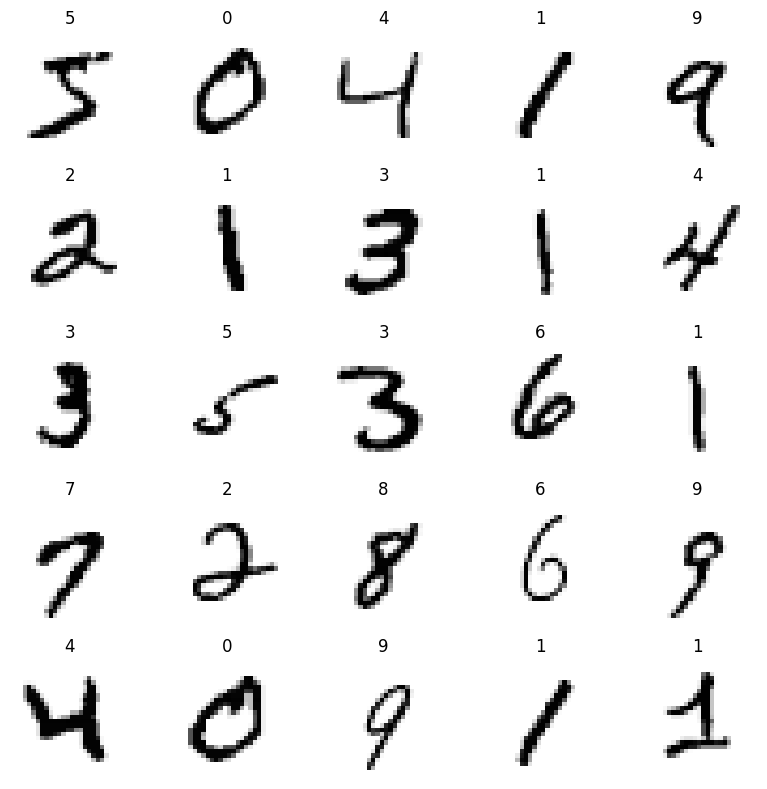

In [12]:
def plot_images(images, labels, nrows=5, ncols=5, vmin=0, vmax=255):
  fig, axes =plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(8,8)) #figsize in inches, share axes means the plots all share the same axes
  for i in range(nrows*ncols):
    ax=axes.flatten()[i]
    image=images[i]
    label=labels[i]

    ax.set_title(label)
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap="Greys")
    ax.set_aspect('equal')
    ax.axis("off")
  fig.tight_layout()
  fig.show()

plot_images(Xtrn,Ytrn)

# Normalize the images

In [14]:
def normalize_255(array):
  normed_array=array/255
  return normed_array

XtrnN=normalize_255(Xtrn)
XtstN=normalize_255(Xtst)

XtrnN.min(), XtrnN.max()

(0.0, 1.0)

# Reshape the arrays for Keras

In [15]:
XtrnN.shape

(60000, 28, 28)

In [19]:
def reshape_for_keras(array):
  reshaped_array = array[...,None] #... indexes all of the dimensions, None at the end means add another axis
  return reshaped_array
XtrnNR = reshape_for_keras(XtrnN)
XtstNR = reshape_for_keras(XtstN)

XtrnNR.shape #has 4 values since now we have 4 dimensions

(60000, 28, 28, 1)

# One-hot encode the image labels

In [17]:
YtrnOH=keras.utils.to_categorical(Ytrn, 10) #don't care because we don't need the labels

YtrnOH.shape

(60000, 10)

# But wait we don't need the image labels...

### The training set will be the images at half resolution, and the model will try to up-sample the images to the original resolution... `Xtrn` should be the same 60,000 images at half resolution, but `Ytrn` should be those same images at the original resolution. We will do the same operations for the testing set.

# Construct dataset for superresolution, not image classification

In [18]:
def build_superres_dataset_from_mnist(X):
  Xnew = deepcopy(X)[:,::2,::2,:] #makes it so there is no relationship between the old object and the new object in the code
  Ynew = deepcopy(X)

  return Xnew, Ynew

XtrnSR, YtrnSR = build_superres_dataset_from_mnist(XtrnNR)
XtstSR, YtstSR = build_superres_dataset_from_mnist(XtstNR)

XtrnSR.shape,YtrnSR.shape,XtstSR.shape,YtstSR.shape,

((60000, 14, 14, 1),
 (60000, 28, 28, 1),
 (10000, 14, 14, 1),
 (10000, 28, 28, 1))

# Visualize the new dataset

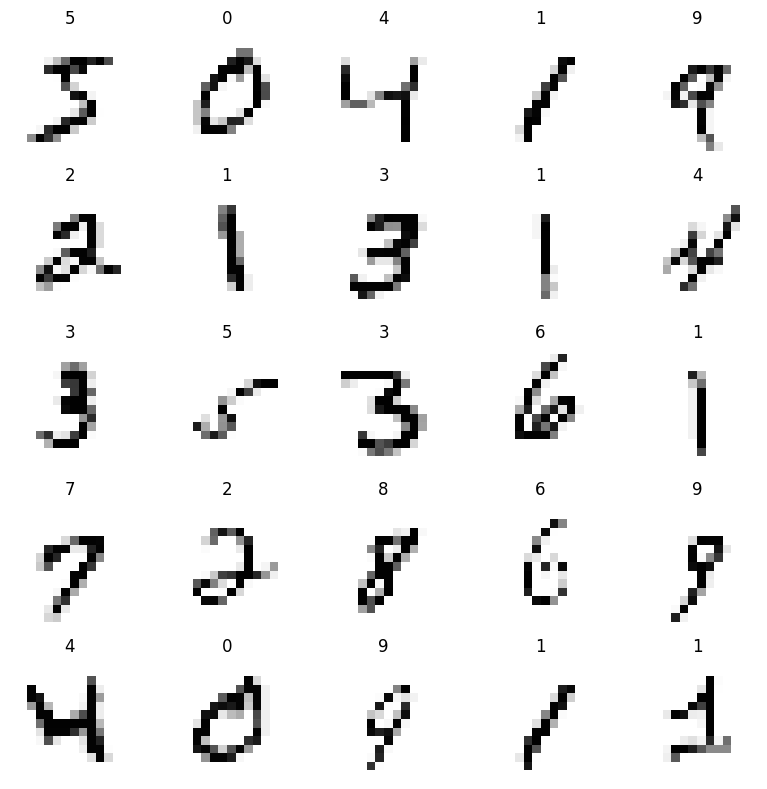

In [22]:
plot_images(XtrnSR[:,:,:,0], Ytrn, vmax=1) #half resolution images

# Build the CNN autoencoder

In [25]:
def build_cnn_autoencoder(input_shape):
  inputs = layers.Input(shape=input_shape)

  #The encoder
  x = layers.Conv2D(16, kernel_size=(3,3), padding="same", activation='relu')(inputs) #convolution layer
  x = layers.Conv2D(8, kernel_size=(3,3), padding="same", activation='relu')(x) #each first number gets halved to reduce the nodes in the layer
  x = layers.Conv2D(4, kernel_size=(3,3), padding="same", activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2))(x)

  shape = x.shape
  num_neurons=shape[1] * shape[2] * shape[3] #this is the shape of the next x layer

  #The latent space
  x=layers.Flatten()(x)
  LS=layers.Dense(16, activation='relu')(x) # at middle point here
  x = layers.Dense(num_neurons, activation='relu')(LS)
  x = layers.Reshape(shape[1:])(x)
  #The decoder
  x = layers.Conv2DTranspose(4, kernel_size=(3,3), padding="same", activation='relu')(x)
  x = layers.Conv2DTranspose(8, kernel_size=(3,3), padding="same", activation='relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding="same", activation='relu')(x)
  x = layers.UpSampling2D(size=(2,2))(x) #doubling the resolution

  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding="same", activation='relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding="same", activation='relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding="same", activation='relu')(x) #all at 14 by 14, want to get to 28 by 28 like we had originally
  x = layers.UpSampling2D(size=(2,2))(x)

  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding="same", activation='sigmoid')(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding="same", activation='sigmoid')(x)
  outputs = layers.Conv2DTranspose(1, kernel_size=(3,3), padding="same", activation='sigmoid')(x)

  model=keras.Model(inputs,outputs)

  encoder=keras.Model(inputs, LS)
  decoder=keras.Model(LS,outputs)#LS is Latent Space
  return model,encoder,decoder

input_shape=XtrnSR.shape[1:]
model, encoder, decoder=build_cnn_autoencoder(input_shape)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 4)           0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 196)               0         
                                                           

# Train the model (use a GPU)

In [26]:
model.compile(loss="mse", optimizer="adam")#use mse like a regression function
history = model.fit(XtrnSR, YtrnSR, batch_size=256, epochs=15, validation_split=0.1)

Epoch 1/15
211/211 [==============================] - 18s 19ms/step - loss: 0.1303 - val_loss: 0.0952
Epoch 2/15
211/211 [==============================] - 3s 12ms/step - loss: 0.0785 - val_loss: 0.0536
Epoch 3/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0416 - val_loss: 0.0332
Epoch 4/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0299 - val_loss: 0.0266
Epoch 5/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0252 - val_loss: 0.0238
Epoch 6/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0228 - val_loss: 0.0215
Epoch 7/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0211 - val_loss: 0.0206
Epoch 8/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0199 - val_loss: 0.0191
Epoch 9/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0190 - val_loss: 0.0185
Epoch 10/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0183 - val_l

# Visualize loss curve

# Visualize the predictions

In [27]:
PtstSR=model.predict(XtstSR)#P for predict
PtstSR.shape

313/313 [==============================] - 1s 3ms/step


(10000, 28, 28, 1)

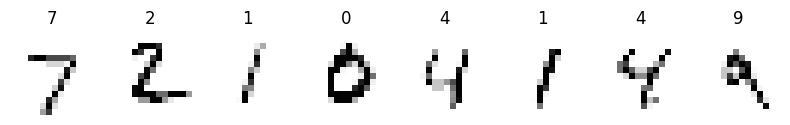

In [28]:
plot_images(XtstSR[..., 0],Ytst, nrows=1,ncols=8,vmax=1) #half resolution images

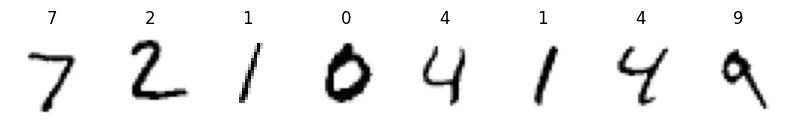

In [29]:
plot_images(YtstSR[..., 0],Ytst, nrows=1,ncols=8,vmax=1) #what they should be

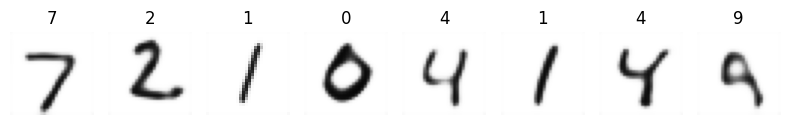

In [30]:
plot_images(PtstSR[..., 0],Ytst, nrows=1,ncols=8,vmax=1) #predicted after rebuilding

# Visualize the early layers

In [33]:
model.layers[1].get_weights()[0].shape #1 is not input layer, its the second layer since index starts at 0
#16 filters, 3 kernals?

(3, 3, 1, 16)

# Visualize the latent space with the encoder and decoder on their own

In [34]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 4)           0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 196)               0         
                                                           

In [35]:
LS = encoder.predict(XtstSR)
ic(LS.shape)
LS_images=LS.reshape((10_000,4,4))

313/313 [==============================] - 1s 2ms/step


ic| LS.shape: (10000, 16)


# Find the average latent space representation for each digit

# Decode latent space representations with the decoder

# What if we input something in the latent space by hand and then decode it?